In [1]:

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt # NOTE: This was tested with matplotlib v. 2.1.0
 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
#########################
#
# Data Import
#
#########################
df = pd.read_csv('../../_data/operations_imputed_CLEAN.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91862 entries, 0 to 102290
Data columns (total 64 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   op_id              91862 non-null  int64  
 1   subject_id         91862 non-null  int64  
 2   hadm_id            91862 non-null  int64  
 3   opdate             91862 non-null  int64  
 4   age                91862 non-null  int64  
 5   sex                91862 non-null  object 
 6   weight             90910 non-null  float64
 7   height             91326 non-null  float64
 8   race               91862 non-null  object 
 9   asa                89532 non-null  float64
 10  emop               91862 non-null  int64  
 11  department         91862 non-null  object 
 12  antype             91862 non-null  object 
 13  icd10_pcs          91862 non-null  object 
 14  category_desc      91862 non-null  object 
 15  desc_short         91862 non-null  object 
 16  category_id        91862 n

In [3]:
#########################
#
# Drop Target Column, NaN columns and excluded Features
#
#########################
# 
## Drop cols with many NaN

columns_w_NaN = ['art_dbp']  # Define as a list

## Drop Excluded Features
cols_to_drop = columns_w_NaN + ['op_id', 'subject_id', 'hadm_id', 'opdate', 'is_outlier', 'category_desc', 'desc_short', 'subject_id_y', 'inhosp_death_time', 'orin_time', 'orout_time', 'opstart_time', 'opend_time', 'admission_time', 'discharge_time', 'anstart_time', 'anend_time', 'cpbon_time', 'cpboff_time', 'icuin_time', 'icuout_time', 'icd10_pcs', 'chart_time_x', 'race', 'emop', 'prolonged_LOS']  # Include 'art_dbp' directly


# Check if the columns exist in the DataFrame before dropping them
missing_columns = [col for col in cols_to_drop if col not in df.columns]
if missing_columns:
    print("Columns not found in DataFrame:", missing_columns)

x_df = df.drop(columns=cols_to_drop, axis=1)

# Drop Targets
y_target_reg = 'LOS'

# Confirm
# x_df = df.drop([y_target_reg], axis=1)

# Check the info of the resulting DataFrame
x_df.info()

# Display the resulting DataFrame
print(x_df)

<class 'pandas.core.frame.DataFrame'>
Index: 91862 entries, 0 to 102290
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              91862 non-null  int64  
 1   sex              91862 non-null  object 
 2   weight           90910 non-null  float64
 3   height           91326 non-null  float64
 4   asa              89532 non-null  float64
 5   department       91862 non-null  object 
 6   antype           91862 non-null  object 
 7   category_id      91862 non-null  object 
 8   art_mbp          89504 non-null  float64
 9   art_sbp          89497 non-null  float64
 10  bt               89479 non-null  float64
 11  cvp              89248 non-null  float64
 12  hr               89515 non-null  float64
 13  pip              89519 non-null  float64
 14  pmean            89508 non-null  float64
 15  rr               89517 non-null  float64
 16  spo2             89517 non-null  float64
 17  vt              

In [4]:
x_df = x_df.dropna()
x_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87844 entries, 3 to 102290
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              87844 non-null  int64  
 1   sex              87844 non-null  object 
 2   weight           87844 non-null  float64
 3   height           87844 non-null  float64
 4   asa              87844 non-null  float64
 5   department       87844 non-null  object 
 6   antype           87844 non-null  object 
 7   category_id      87844 non-null  object 
 8   art_mbp          87844 non-null  float64
 9   art_sbp          87844 non-null  float64
 10  bt               87844 non-null  float64
 11  cvp              87844 non-null  float64
 12  hr               87844 non-null  float64
 13  pip              87844 non-null  float64
 14  pmean            87844 non-null  float64
 15  rr               87844 non-null  float64
 16  spo2             87844 non-null  float64
 17  vt              

In [5]:
#########################
#
# One-Hot encode categorical Features
#
#########################

# Filter columns with dtype 'object'
object_columns = x_df.select_dtypes(include='object').columns.tolist()
numeric_columns = ['asa']
encode_columns = object_columns +numeric_columns

print(encode_columns)



['sex', 'department', 'antype', 'category_id', 'asa']


In [6]:
from sklearn.preprocessing import OneHotEncoder
## use OneHot instead of get_dummies
        
def encode_cat_vars(x, columns_to_encode):
    original_cols = set(x.columns)
    
    # Extract the object columns
    
    # object_columns = [col for col in x.columns if col in columns_to_encode]
    
    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(drop='first', sparse=False)
    
    # Fit and transform the encoder on the object columns
    encoded_data = encoder.fit_transform(x[columns_to_encode])
    
    # Create a DataFrame from the encoded data with appropriate column names
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))
    
    # Drop the original object columns
    x = x.drop(columns_to_encode, axis=1)
    
    # Concatenate the encoded DataFrame with the original DataFrame
    x = pd.concat([x, encoded_df], axis=1)
    
    # Get the newly added columns
    dummy_cols = list(set(x.columns) - original_cols)
    
    return x, dummy_cols

# Dummy variable creation is done before splitting the data, so all the different categories are covered
# Create dummy variables
df_encoded, dummy_columns = encode_cat_vars(x_df, encode_columns)

#confirm:
# df_encoded = df_encoded.dropna(subset=['LOS'])
print(dummy_columns)
df_encoded


c:\Users\jamie\anaconda3\envs\Lighthouse_env\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['asa_4.0', 'category_id_0SS', 'category_id_0BW', 'department_OG', 'category_id_0SG', 'category_id_0D1', 'category_id_0M9', 'category_id_021', 'sex_M', 'category_id_0DT', 'category_id_0VB', 'category_id_0BQ', 'category_id_0HB', 'category_id_0HX', 'department_UR', 'category_id_09R', 'category_id_0NB', 'category_id_0UV', 'category_id_0W9', 'category_id_0SB', 'category_id_0DQ', 'category_id_0GQ', 'category_id_0BY', 'category_id_0FB', 'category_id_0PB', 'category_id_02J', 'category_id_089', 'category_id_02H', 'category_id_099', 'category_id_0QS', 'category_id_0SW', 'category_id_02L', 'category_id_09B', 'category_id_0RG', 'category_id_04R', 'category_id_00Q', 'category_id_0DN', 'category_id_0R9', 'category_id_03B', 'category_id_0BJ', 'category_id_03L', 'department_CTS', 'category_id_031', 'category_id_0PS', 'category_id_00P', 'category_id_0HQ', 'category_id_0H9', 'antype_Regional', 'category_id_04C', 'category_id_0RB', 'asa_5.0', 'department_OS', 'category_id_0HD', 'category_id_0Q9', 'categ

,age,weight,height,art_mbp,art_sbp,bt,cvp,hr,pip,pmean,...,category_id_0WB,category_id_0WJ,category_id_0Y6,category_id_0YH,category_id_10D,asa_2.0,asa_3.0,asa_4.0,asa_5.0,asa_6.0
3,50.0,66.0,157.0,100.826720,137.244265,29.656043,2.457447,78.792763,4.000000,4.893834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,60.0,62.0,154.0,100.773779,138.601562,28.462637,0.603448,62.000000,5.000000,4.485501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,35.0,50.0,160.0,98.084871,131.646617,29.201952,7.653846,82.000000,13.546358,3.803659,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,20.0,62.0,179.0,92.702290,140.826772,35.800000,0.272727,94.000000,12.820417,4.017967,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,60.0,52.0,152.0,100.773779,138.601562,28.462637,0.603448,68.000000,4.000000,4.485501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
87818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
87822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
87830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
df_encoded=df_encoded.dropna()

df_encoded.to_csv('../../_data/1hot_encoded.csv')

Split the PCA into three components - dempographic, operation, clinical

In [8]:
df_columns = df_encoded.columns.to_list()
print(df_columns)

['age', 'weight', 'height', 'art_mbp', 'art_sbp', 'bt', 'cvp', 'hr', 'pip', 'pmean', 'rr', 'spo2', 'vt', 'chart_time_y', 'alp', 'alt', 'ast', 'chloride', 'creatinine', 'glucose', 'hb', 'hco3', 'lymphocyte', 'platelet', 'potassium', 'sodium', 'total_bilirubin', 'wbc', 'LOS', 'icu_visit', 'or_duration', 'anesth_duration', 'sex_M', 'department_CTS', 'department_DM', 'department_EM', 'department_GS', 'department_IM', 'department_NS', 'department_OG', 'department_OL', 'department_OS', 'department_OT', 'department_PED', 'department_PS', 'department_RAD', 'department_UR', 'antype_MAC', 'antype_Neuraxial', 'antype_Regional', 'category_id_009', 'category_id_00B', 'category_id_00J', 'category_id_00P', 'category_id_00Q', 'category_id_00X', 'category_id_021', 'category_id_027', 'category_id_02B', 'category_id_02C', 'category_id_02H', 'category_id_02J', 'category_id_02L', 'category_id_02Q', 'category_id_02R', 'category_id_02S', 'category_id_02V', 'category_id_02Y', 'category_id_031', 'category_id_0

In [9]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.decomposition import PCA
#########################
#
# Scaling Data
#
#########################
# 
target_column = y_target_reg  # Replace with the y_regression if want to change model to regression. 
#object_columns = [col for col in df_encoded.columns if col != target_column]
demographic_columns = ['age',
                        'weight',
                        'height',
                        'sex_M',
                        'asa_2.0',
                        'asa_3.0',
                        'asa_4.0',
                        'asa_5.0',
                        'asa_6.0'
                        ]
operation_columns =['icu_visit',
                    'or_duration',
                    'anesth_duration',
                    'department_CTS',
                    'department_DM',
                    'department_EM',
                    'department_GS',
                    'department_IM',
                    'department_NS',
                    'department_OG',
                    'department_OL',
                    'department_OS',
                    'department_OT',
                    'department_PED',
                    'department_PS',
                    'department_RAD',
                    'department_UR',
                    'antype_MAC',
                    'antype_Neuraxial',
                    'antype_Regional'
                    ]
clinical_columns = ['art_mbp',
                    'art_sbp',
                    'bt',
                    'cvp',
                    'hr',
                    'pip',
                    'pmean',
                    'rr',
                    'spo2',
                    'vt',
                    'chart_time_y',
                    'alp',
                    'alt',
                    'ast',
                    'chloride',
                    'creatinine',
                    'glucose',
                    'hb',
                    'hco3',
                    'lymphocyte',
                    'platelet',
                    'potassium',
                    'sodium',
                    'total_bilirubin',
                    'wbc'
                    ]
procdure_colums = ['category_id_009',
                    'category_id_00B',
                    'category_id_00J',
                    'category_id_00P',
                    'category_id_00Q',
                    'category_id_00X',
                    'category_id_021',
                    'category_id_027',
                    'category_id_02B',
                    'category_id_02C',
                    'category_id_02H',
                    'category_id_02J',
                    'category_id_02L',
                    'category_id_02Q',
                    'category_id_02R',
                    'category_id_02S',
                    'category_id_02V',
                    'category_id_02Y',
                    'category_id_031',
                    'category_id_03B',
                    'category_id_03C',
                    'category_id_03L',
                    'category_id_041',
                    'category_id_047',
                    'category_id_04B',
                    'category_id_04C',
                    'category_id_04R',
                    'category_id_05H',
                    'category_id_07L',
                    'category_id_089',
                    'category_id_08D',
                    'category_id_08R',
                    'category_id_099',
                    'category_id_09B',
                    'category_id_09P',
                    'category_id_09Q',
                    'category_id_09R',
                    'category_id_0B1',
                    'category_id_0BB',
                    'category_id_0BD',
                    'category_id_0BJ',
                    'category_id_0BN',
                    'category_id_0BQ',
                    'category_id_0BT',
                    'category_id_0BW',
                    'category_id_0BY',
                    'category_id_0CJ',
                    'category_id_0CR',
                    'category_id_0D1',
                    'category_id_0DB',
                    'category_id_0DH',
                    'category_id_0DJ',
                    'category_id_0DN',
                    'category_id_0DQ',
                    'category_id_0DT',
                    'category_id_0DV',
                    'category_id_0F9',
                    'category_id_0FB',
                    'category_id_0FQ',
                    'category_id_0FT',
                    'category_id_0FY',
                    'category_id_0GQ',
                    'category_id_0GT',
                    'category_id_0H8',
                    'category_id_0H9',
                    'category_id_0HB',
                    'category_id_0HD',
                    'category_id_0HQ',
                    'category_id_0HR',
                    'category_id_0HX',
                    'category_id_0J8',
                    'category_id_0JB',
                    'category_id_0KQ',
                    'category_id_0M9',
                    'category_id_0MB',
                    'category_id_0N9',
                    'category_id_0NB',
                    'category_id_0NP',
                    'category_id_0NQ',
                    'category_id_0PB',
                    'category_id_0PH',
                    'category_id_0PP',
                    'category_id_0PS',
                    'category_id_0Q9',
                    'category_id_0QH',
                    'category_id_0QQ',
                    'category_id_0QS',
                    'category_id_0R9',
                    'category_id_0RB',
                    'category_id_0RG',
                    'category_id_0RH',
                    'category_id_0RP',
                    'category_id_0RW',
                    'category_id_0SB',
                    'category_id_0SG',
                    'category_id_0SP',
                    'category_id_0SR',
                    'category_id_0SS',
                    'category_id_0SW',
                    'category_id_0TB',
                    'category_id_0TT',
                    'category_id_0UT',
                    'category_id_0UV',
                    'category_id_0VB',
                    'category_id_0VC',
                    'category_id_0W1',
                    'category_id_0W2',
                    'category_id_0W3',
                    'category_id_0W9',
                    'category_id_0WB',
                    'category_id_0WJ',
                    'category_id_0Y6',
                    'category_id_0YH',
                    'category_id_10D'
                    ]

# Initialize the HistGradientBoostingRegression for feature selection

# demographic_columns
# operation_columns
# clinical_columns
# procdure_colums



In [38]:
#########################
#
# Principal Component Analysis - PCA - Demographics
#
#########################
# Perform PCA on the final_data

demog_PCA_df = df_encoded.drop(columns=operation_columns + clinical_columns + procdure_colums)

# Assuming 'demog_PCA_df' is your original DataFrame with both features and the target 'LOS'
scaler = StandardScaler()

# Separate features (X) and target (y)
X = demog_PCA_df.drop(['LOS'], axis=1)
y = demog_PCA_df['LOS']

# Get the column names before scaling
column_names = X.columns.tolist()

# Standardize the feature data
X = scaler.fit_transform(X)

# Create a DataFrame with standardized features and reset column names
dfx = pd.DataFrame(data=X, columns=column_names)

# dfx now contains standardized features for PCA
dfx.head(10)

,age,weight,height,sex_M,asa_2.0,asa_3.0,asa_4.0,asa_5.0,asa_6.0
0,-0.422773,0.269151,-0.076263,1.123618,-1.172237,-0.309908,-0.058724,-0.010971,-0.006334
1,0.221077,-0.063457,-0.123065,-0.889982,-1.172237,-0.309908,-0.058724,-0.010971,-0.006334
2,-1.388547,-1.061279,-0.029461,-0.889982,0.853070,-0.309908,-0.058724,-0.010971,-0.006334
3,-2.354321,-0.063457,0.266951,-0.889982,0.853070,-0.309908,-0.058724,-0.010971,-0.006334
4,0.221077,-0.894975,-0.154267,-0.889982,-1.172237,-0.309908,-0.058724,-0.010971,-0.006334
5,1.186851,0.185999,-0.123065,1.123618,0.853070,-0.309908,-0.058724,-0.010971,-0.006334
6,0.864926,-0.146608,-0.201069,1.123618,-1.172237,-0.309908,-0.058724,-0.010971,-0.006334
7,0.221077,-0.811823,-0.201069,1.123618,-1.172237,-0.309908,-0.058724,-0.010971,-0.006334
8,-0.422773,0.768062,0.251351,-0.889982,0.853070,-0.309908,-0.058724,-0.010971,-0.006334
9,-0.100848,-1.393886,-0.154267,1.123618,0.853070,-0.309908,-0.058724,-0.010971,-0.006334


In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

dfx_pca = pca.fit(dfx)

pca.explained_variance_ratio_

array([0.15272011, 0.13047847, 0.11422108])

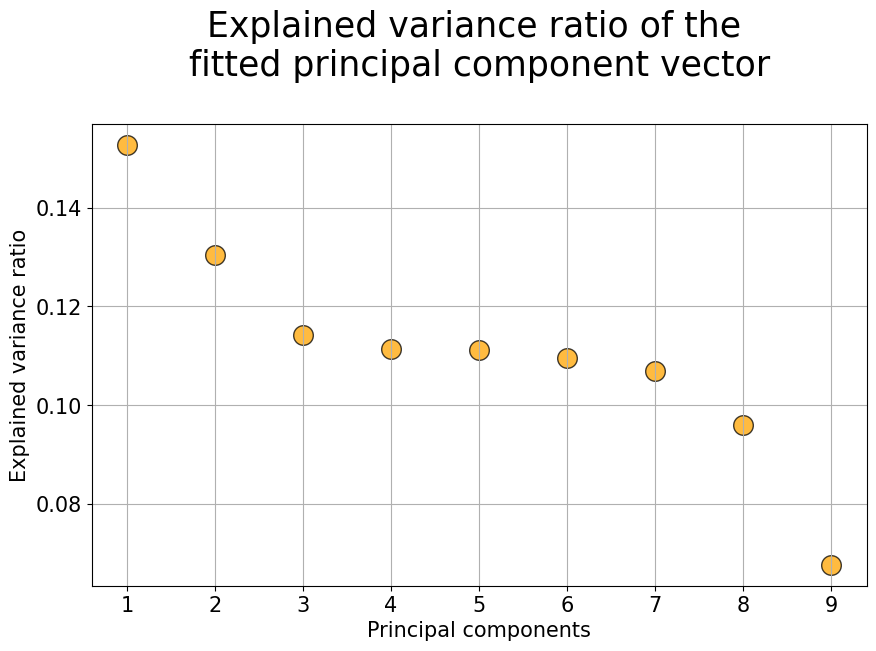

In [21]:
# A SKREE PLOT:
# Purpose - to determine if your PCA (is doing its job) 

plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],
            y=dfx_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()



In [ ]:
 
#########################
#
# Determine which genes had the biggest influence on PC1
#
#########################


TypeError: 'PCA' object is not subscriptable

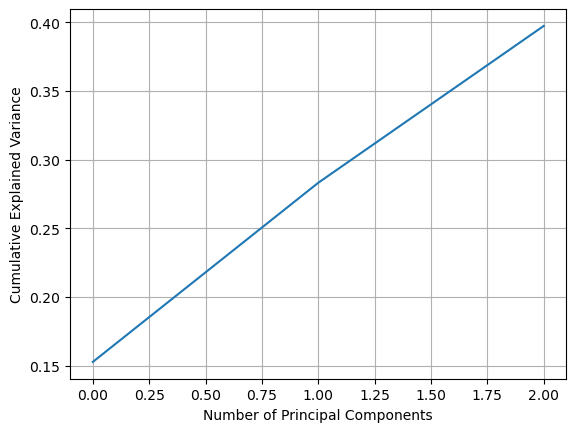

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Explained variance ratios from PCA
explained_variance_ratios = np.array([0.15272011, 0.13047847, 0.11422108])

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratios)

# Plot the cumulative explained variance curve
plt.plot(cumulative_explained_variance)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()

# Choose a threshold for the cumulative explained variance (e.g., 95%)
desired_variance_retention = 0.95

# Find the number of principal components that meet the desired variance retention
num_components = np.argmax(cumulative_explained_variance >= desired_variance_retention) + 1

# Select the most meaningful principal components
selected_principal_components = dfx_pca[:, :num_components]

# Use the principal components to identify the most influential original features
# You can examine the loadings or coefficients of the principal components to determine feature importance


In [44]:

# For example, you can get the loadings of the first principal component
loadings_pc1 = pca.components_[0]

# Sort the loadings by magnitude to identify the most influential original features
most_influential_features = np.argsort(np.abs(loadings_pc1))[::-1]

# Now, most_influential_features contains the indices of the original features in descending order of importance

# Print or use these feature indices as needed
print("Most Influential Features:", most_influential_features)

# Map the indices to feature names in your original DataFrame
most_influential_feature_names = [column_names[i] for i in most_influential_features]

# Print or use these feature names as needed
print("Most Influential Features:", most_influential_feature_names)


Most Influential Features: [5 4 3 6 7 2 8 1 0]
Most Influential Features: ['asa_3.0', 'asa_2.0', 'sex_M', 'asa_4.0', 'asa_5.0', 'height', 'asa_6.0', 'weight', 'age']


In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

##############################
#
#   REFERENCE INFO: 
#    df_encoded = baseline df with encoded. No scaling 
#   demographic_columns
#   operation_columns
#   clinical_columns
#   procdure_colums
#
#################################
# Sample data (replace this with your actual data)
data = df_encoded

# Separate features and target
X = data.drop(columns=['LOS'])
y = data['LOS']

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define feature groups as a dictionary with labels
feature_groups = {
    'demographic_columns': demographic_columns,
    'operation_columns': operation_columns,
    'clinical_columns': clinical_columns,
    'procdure_colums':procdure_colums }

# Iterate through feature groups and perform PCA on each group
for label, features in feature_groups.items():
    # Create a DataFrame with the selected feature group
    X_subset = X[features]
    
    # Standardize the subset of features
    X_subset_scaled = scaler.fit_transform(X_subset)
    
    # Perform PCA on the subset
    pca = PCA(n_components=5)  # Set N to your desired number of components
    pca.fit(X_subset_scaled)
    
    # Iterate through the first N principal components for this group
    for component in range(5):
        # Loadings of the component
        loadings = pca.components_[component]
        
        # Explained variance of the component
        explained_variance = pca.explained_variance_ratio_[component]
        
        # Combine loadings, explained variance, and feature names
        component_summary = pd.DataFrame({
            'Loadings': loadings,
            'Explained Variance': explained_variance,
            'Feature Names': features
        })
        
        # Sort by magnitude of loadings for better interpretation
        component_summary['Abs Loadings'] = np.abs(component_summary['Loadings'])
        component_summary = component_summary.sort_values(by='Abs Loadings', ascending=False).drop(columns='Abs Loadings')
        
        # Print the summary for the component and feature group
        print(f"Feature Group: {label}, PCA Iteration {component + 1}, Principal Component {component + 1} Summary:")
        print(component_summary)
        print("\n")


Feature Group: demographic_columns, PCA Iteration 1, Principal Component 1 Summary:
   Loadings  Explained Variance Feature Names
5  0.699006             0.15272       asa_3.0
4 -0.692357             0.15272       asa_2.0
3  0.141357             0.15272         sex_M
6  0.106740             0.15272       asa_4.0
7  0.021903             0.15272       asa_5.0
2 -0.008490             0.15272        height
8  0.007808             0.15272       asa_6.0
1  0.006667             0.15272        weight
0 -0.001016             0.15272           age


Feature Group: demographic_columns, PCA Iteration 2, Principal Component 2 Summary:
   Loadings  Explained Variance Feature Names
1  0.657991            0.130478        weight
0 -0.594166            0.130478           age
2  0.462038            0.130478        height
7  0.013976            0.130478       asa_5.0
8 -0.012397            0.130478       asa_6.0
6 -0.012215            0.130478       asa_4.0
3 -0.004491            0.130478         sex_M
4 